This is for Chapter 13 and Week 8 homework from [Winter 2020 of Statistical Rethinking](https://github.com/rmcelreath/stat_rethinking_2020/tree/main/homework) using Python. A public repo using `pmyc3` has been created [here](https://github.com/pymc-devs/resources/tree/master/Rethinking_2) that also uses Python.

In [90]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit as logistic
from scipy.special import logit
import daft
from causalgraphicalmodels import CausalGraphicalModel

from scipy.optimize import curve_fit

<IPython.core.display.Javascript object>

In [3]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [4]:
sns.set_context("talk")

<IPython.core.display.Javascript object>

In [5]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Question 1 (13H4)

Revisit the Reed frog survival data, `data(reedfrogs)`, and add the `predation` and `size` treatment variables to the varying intercepts model. Consider models with either predictor alone, both predictors, as well as a model including their interaction. What do you infer about the causal influence of these predictor variables? Also focus on the inferred variation across tanks (the σ across tanks). Explain why it changes as it does across models with different predictors included.

## Data exploration and setup

In [6]:
df_frogs = pd.read_csv(
    "../pymc3_ed_resources/resources/Rethinking_2/Data/reedfrogs.csv",
    delimiter=",",
)
df_frogs.head()

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


<IPython.core.display.Javascript object>

In [7]:
print("shape of df: ", df_frogs.shape)

shape of df:  (48, 5)


<IPython.core.display.Javascript object>

## Setup code from book chapter

**Model 13.2 equation**: the varying intercepts model.

$$S_i \text{ ~ } \text{Binomial}(N_i,p_i)$$

$$\text{logit}(p_i) = \alpha_{\text{TANK}[i]}$$

$$\alpha_j \text{ ~ } \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\bar{\alpha} \text{ ~ } \text{Normal}(0, 1.5) \tag{prior for average tank}$$

$$\sigma \text{ ~ } \text{Exponential}(1) \tag{prior for standard deviation of tanks}$$

In [13]:
# make the tank cluster variable
tank = np.arange(df_frogs.shape[0])
n_tanks = df_frogs.shape[0]

<IPython.core.display.Javascript object>

In [16]:
# modified from repo
with pm.Model() as m_13_2:
    # adaptive prior
    a_bar = pm.Normal("a_bar", 0.0, 1.5)

    # prior for SD of tanks
    sigma = pm.Exponential("sigma", 1.0)

    # adaptive prior
    a = pm.Normal("a", a_bar, sigma, shape=n_tanks)

    p = pm.math.invlogit(a[tank])

    S = pm.Binomial("S", n=df_frogs["density"], p=p, observed=df_frogs["surv"])

    trace_13_2 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


<IPython.core.display.Javascript object>

In [18]:
az.summary(trace_13_2, round_to=3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,1.352,0.254,0.952,1.758,0.003,0.002,5715.665,5470.315,5711.172,3386.714,0.999
a[0],2.139,0.882,0.816,3.580,0.011,0.010,6662.886,4232.009,7503.335,3125.399,1.000
a[1],3.112,1.137,1.318,4.841,0.015,0.012,5957.781,4310.665,6777.537,3037.606,1.001
a[2],1.005,0.679,-0.101,2.018,0.008,0.007,7801.412,4315.975,7989.760,3004.607,1.000
a[3],3.092,1.126,1.254,4.744,0.015,0.012,5809.783,4096.342,6746.887,2344.202,1.000
a[4],2.145,0.876,0.790,3.528,0.011,0.009,6883.972,4502.372,7969.451,3021.223,1.002
a[5],2.131,0.898,0.768,3.527,0.011,0.010,6615.501,3982.368,7701.853,2687.314,1.001
a[6],3.073,1.078,1.304,4.697,0.015,0.013,4981.800,3476.427,5834.499,2545.804,1.004
a[7],2.131,0.840,0.741,3.382,0.011,0.009,6043.148,4222.362,6739.969,2994.378,1.000
a[8],-0.165,0.623,-1.175,0.823,0.007,0.010,8418.216,1779.258,8466.938,2807.689,1.002


<IPython.core.display.Javascript object>

## Model with `predation` alone

**Model 13.2p equation**

$$S_i \text{ ~ } \text{Binomial}(N_i,p_i)$$

$$\text{logit}(p_i) = \alpha_{\text{TANK}[i]} + \beta_{\text{PREDATION}[i]}$$

$$\alpha_j \text{ ~ } \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\beta_j \text{ ~ } \text{Normal}(0, 1) \tag{regularizing prior}$$

$$\bar{\alpha} \text{ ~ } \text{Normal}(0, 1.5) \tag{prior for average tank}$$

$$\sigma \text{ ~ } \text{Exponential}(1) \tag{prior for standard deviation of tanks}$$

In [21]:
# Make predation an index variable
df_frogs["pred_code"] = pd.Categorical(df_frogs["pred"]).codes
df_frogs.head()

,density,pred,size,surv,propsurv,pred_code
0,10,no,big,9,0.9,0
1,10,no,big,10,1.0,0
2,10,no,big,7,0.7,0
3,10,no,big,10,1.0,0
4,10,no,small,9,0.9,0


<IPython.core.display.Javascript object>

In [22]:
df_frogs["pred_code"].unique()

array([0, 1], dtype=int8)

<IPython.core.display.Javascript object>

In [23]:
# modified from repo
with pm.Model() as m_13_2p:
    # prior for average tank
    a_bar = pm.Normal("a_bar", 0.0, 1.5)

    # prior for SD of tanks
    sigma = pm.Exponential("sigma", 1.0)

    # adaptive prior
    a = pm.Normal("a", a_bar, sigma, shape=n_tanks)

    # regularizing prior (assume shape will be 2)
    bp = pm.Normal("bp", 0, 1, shape=len(df_frogs["pred_code"].unique()))

    p = pm.math.invlogit(a[tank] + bp[df_frogs["pred_code"]])

    S = pm.Binomial("S", n=df_frogs["density"], p=p, observed=df_frogs["surv"])

    trace_13_2p = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bp, a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5539824831307071, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6334738283771231, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

In [30]:
# Check values to compare with re-parameterized
az.summary(trace_13_2p, var_names=["bp"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bp[0],1.451,0.637,0.373,2.432,0.088,0.063,52.0,52.0,53.0,190.0,1.07
bp[1],-1.093,0.635,-2.154,-0.142,0.096,0.069,43.0,43.0,44.0,158.0,1.07


<IPython.core.display.Javascript object>

### Re-parameterize

**Model 13.2p equation (centered)**

$$S_i \text{ ~ } \text{Binomial}(N_i,p_i)$$

$$\text{logit}(p_i) = \alpha_{\text{TANK}[i]} + \beta_{\text{PREDATION}[i]}$$

$$\alpha_j \text{ ~ } \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\beta_j \text{ ~ } \text{Normal}(0, 1) \tag{regularizing prior}$$

$$\bar{\alpha} \text{ ~ } \text{Normal}(0, 1.5) \tag{prior for average tank}$$

$$\sigma \text{ ~ } \text{Exponential}(1) \tag{prior for standard deviation of tanks}$$

**Model 13.2pr equation (non-centered)**

$$S_i \text{ ~ } \text{Binomial}(N_i,p_i)$$

$$\text{logit}(p_i) = \bar{\alpha} + z_{\text{TANK}[i]}\sigma + \beta_{\text{PREDATION}[i]}$$

$$z_j \text{ ~ } \text{Normal}(0, 1) \tag{standardized tank intercepts}$$

$$\beta_j \text{ ~ } \text{Normal}(0, 1) \tag{regularizing prior}$$

$$\bar{\alpha} \text{ ~ } \text{Normal}(0, 1.5) \tag{prior for average tank}$$

$$\sigma \text{ ~ } \text{Exponential}(1) \tag{prior for standard deviation of tanks}$$

In [25]:
with pm.Model() as m_13_2pr:
    # prior for average tank
    a_bar = pm.Normal("a_bar", 0.0, 1.5)

    # prior for SD of tanks
    sigma = pm.Exponential("sigma", 1.0)

    # standardized tank intercepts
    z = pm.Normal("z", 0, 1, shape=n_tanks)

    # regularizing prior (assume shape will be 2)
    bp = pm.Normal("bp", 0, 1, shape=len(df_frogs["pred_code"].unique()))

    p = pm.math.invlogit(a_bar + z[tank] * sigma + bp[df_frogs["pred_code"]])

    S = pm.Binomial("S", n=df_frogs["density"], p=p, observed=df_frogs["surv"])

    trace_13_2pr = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bp, z, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


<IPython.core.display.Javascript object>

No warnings observed.

### Compare centered and non-centered models

In [52]:
az.summary(trace_13_2p, var_names=["bp", "sigma"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bp[0],1.451,0.637,0.373,2.432,0.088,0.063,52.0,52.0,53.0,190.0,1.07
bp[1],-1.093,0.635,-2.154,-0.142,0.096,0.069,43.0,43.0,44.0,158.0,1.07
sigma,0.827,0.144,0.580,1.038,0.009,0.006,259.0,259.0,247.0,340.0,1.02


<IPython.core.display.Javascript object>

In [53]:
# Check values to compare with centered model.
az.summary(trace_13_2pr, var_names=["bp", "sigma"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bp[0],1.520,0.671,0.471,2.617,0.012,0.008,3341.0,3235.0,3339.0,2852.0,1.0
bp[1],-1.033,0.666,-2.053,0.085,0.012,0.009,3237.0,2853.0,3235.0,2826.0,1.0
sigma,0.820,0.140,0.605,1.044,0.003,0.002,1753.0,1753.0,1772.0,3063.0,1.0


<IPython.core.display.Javascript object>

The number of effective samples (ess = effective sample size) is much larger in the non-centered model! Let's look  more closely at the parameter estimates too.

Text(0.5, 1.0, 'non-centered')

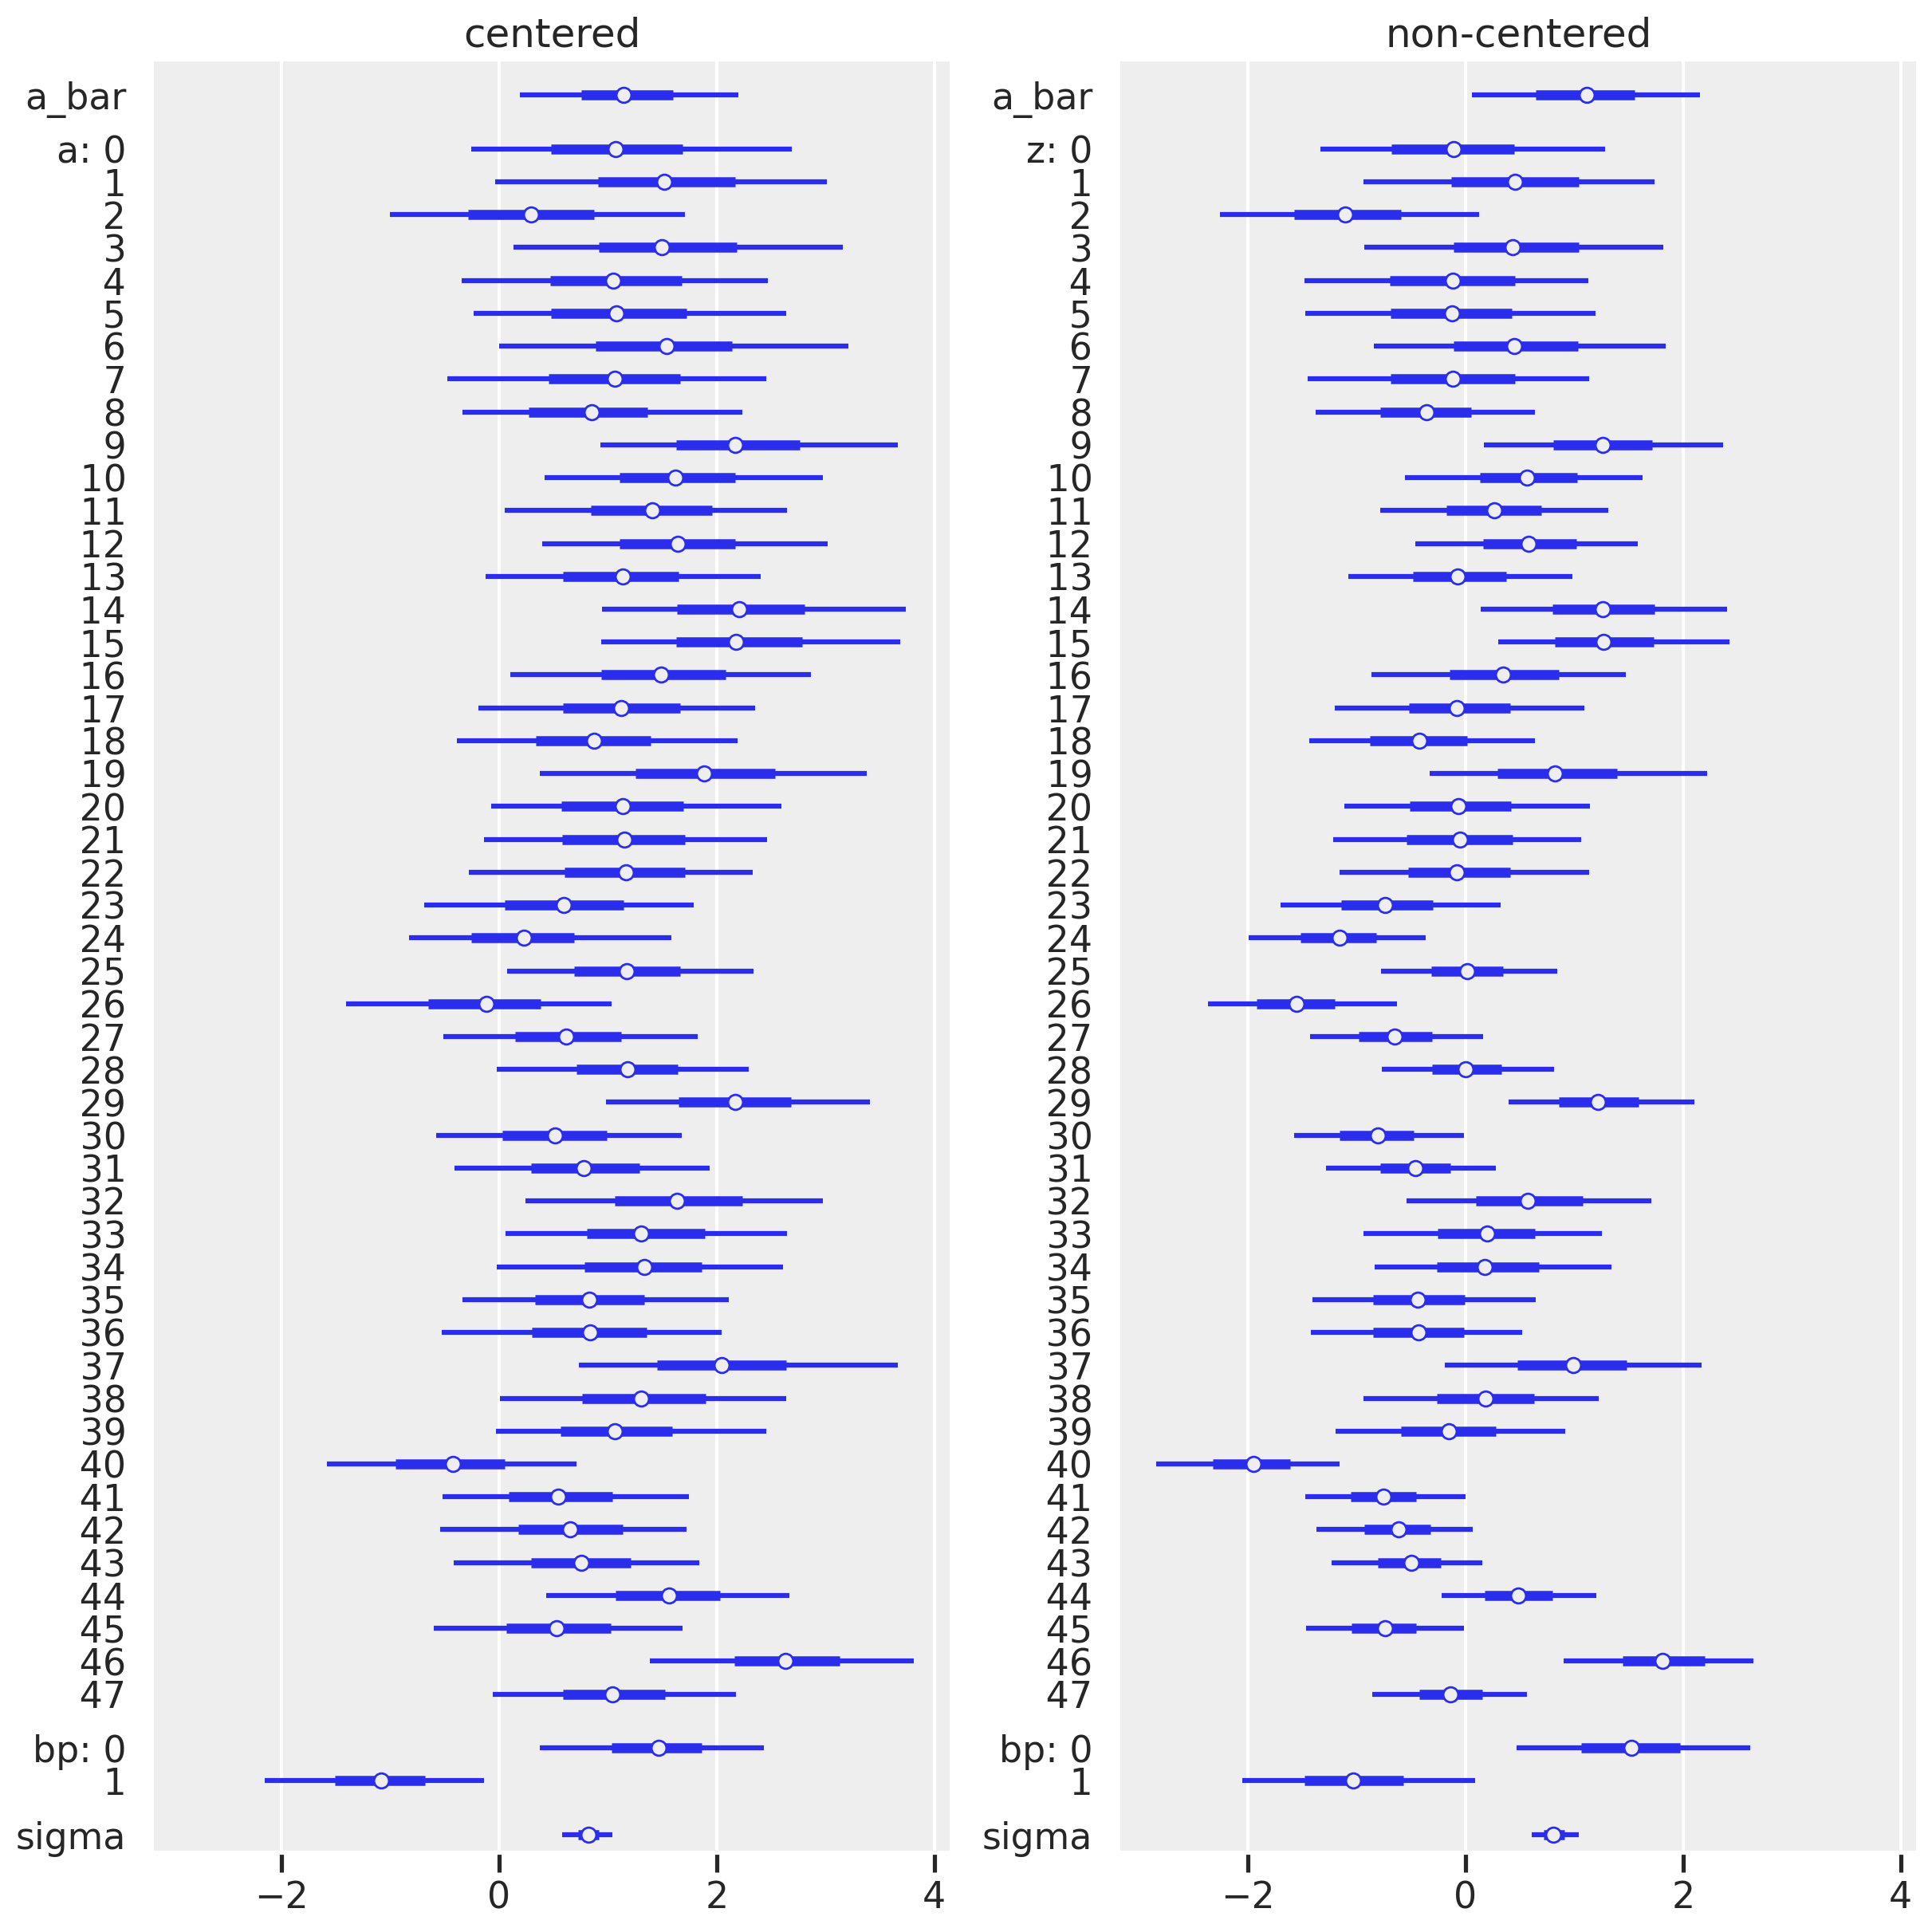

<IPython.core.display.Javascript object>

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12), sharex=True)
az.plot_forest(trace_13_2p, combined=True, ax=ax1)
az.plot_forest(trace_13_2pr, combined=True, ax=ax2)
ax1.set_title('centered')
ax2.set_title('non-centered')


Patterns are largely similar between centered and non-centered parameters but there's some subtlety (see tank 47). The variability also appears tighter.

[Text(0.5, 0, 'centered'),
 Text(0, 0.5, 'non-centered'),
 Text(0.5, 1.0, 'Impact of re-parameterization\non parameter variability')]

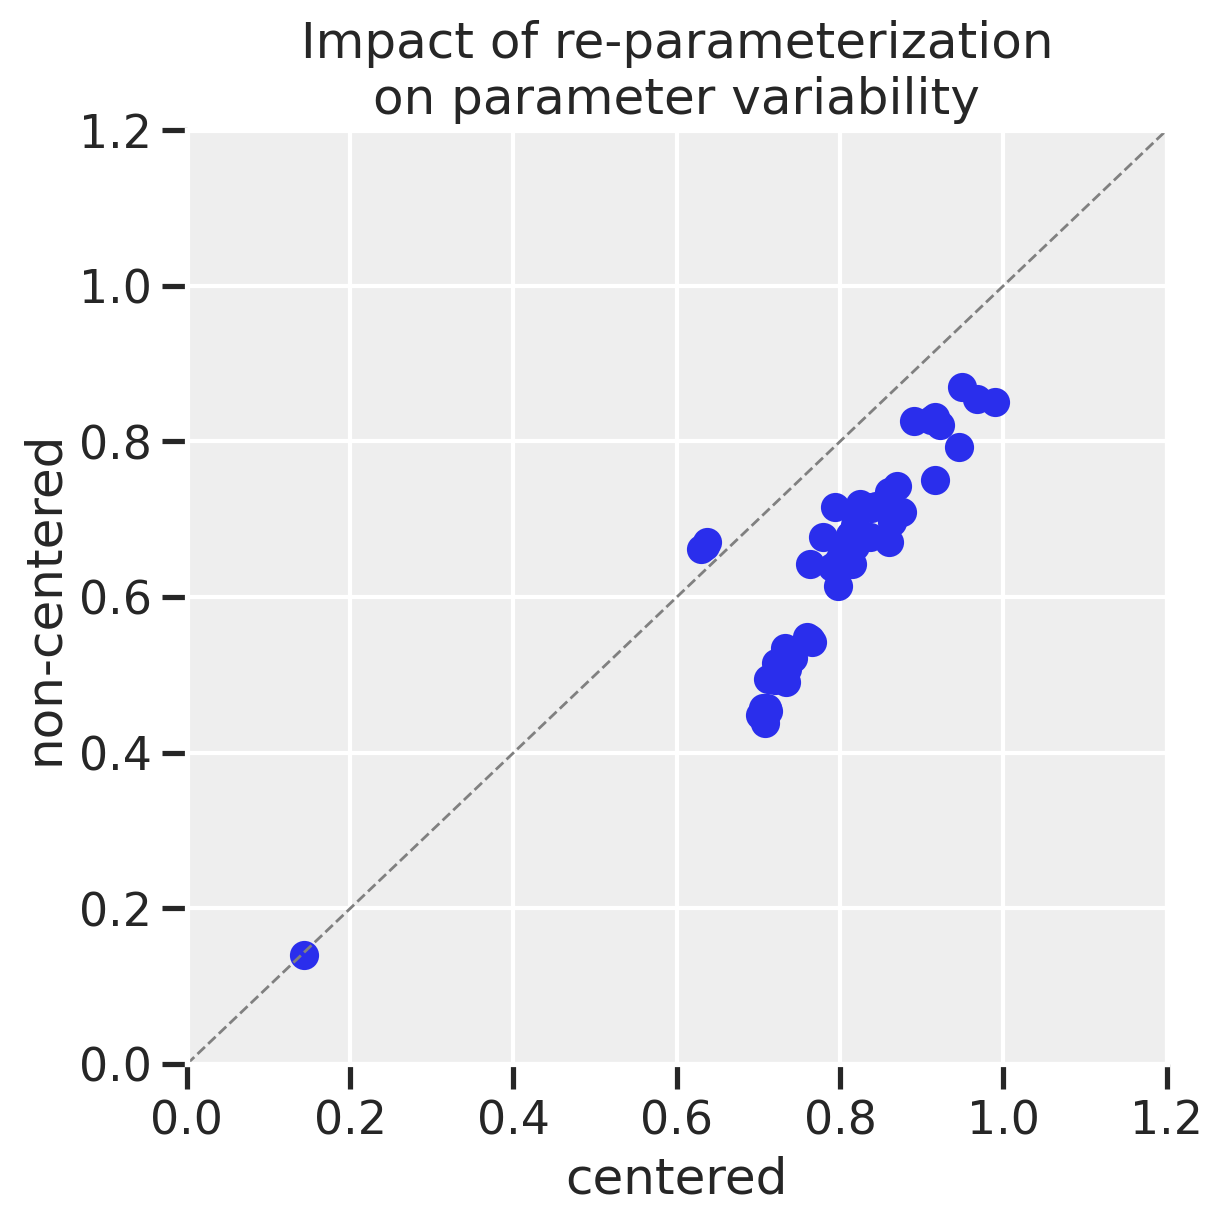

<IPython.core.display.Javascript object>

In [47]:
f, ax1 = plt.subplots(figsize=(6, 6))
ax1.scatter(x=az.summary(trace_13_2p)["sd"], y=az.summary(trace_13_2pr)["sd"])
ax1.set_xlim(0, 1.2)
ax1.set_ylim(0, 1.2)
ax1.axline((0, 0), (1, 1), linewidth=1, linestyle="dashed", color="gray")
ax1.set(
    xlabel="centered",
    ylabel="non-centered",
    title="Impact of re-parameterization\non parameter variability",
)

### Impact of predation

Text(0.5, 0, 'log-odds survival')

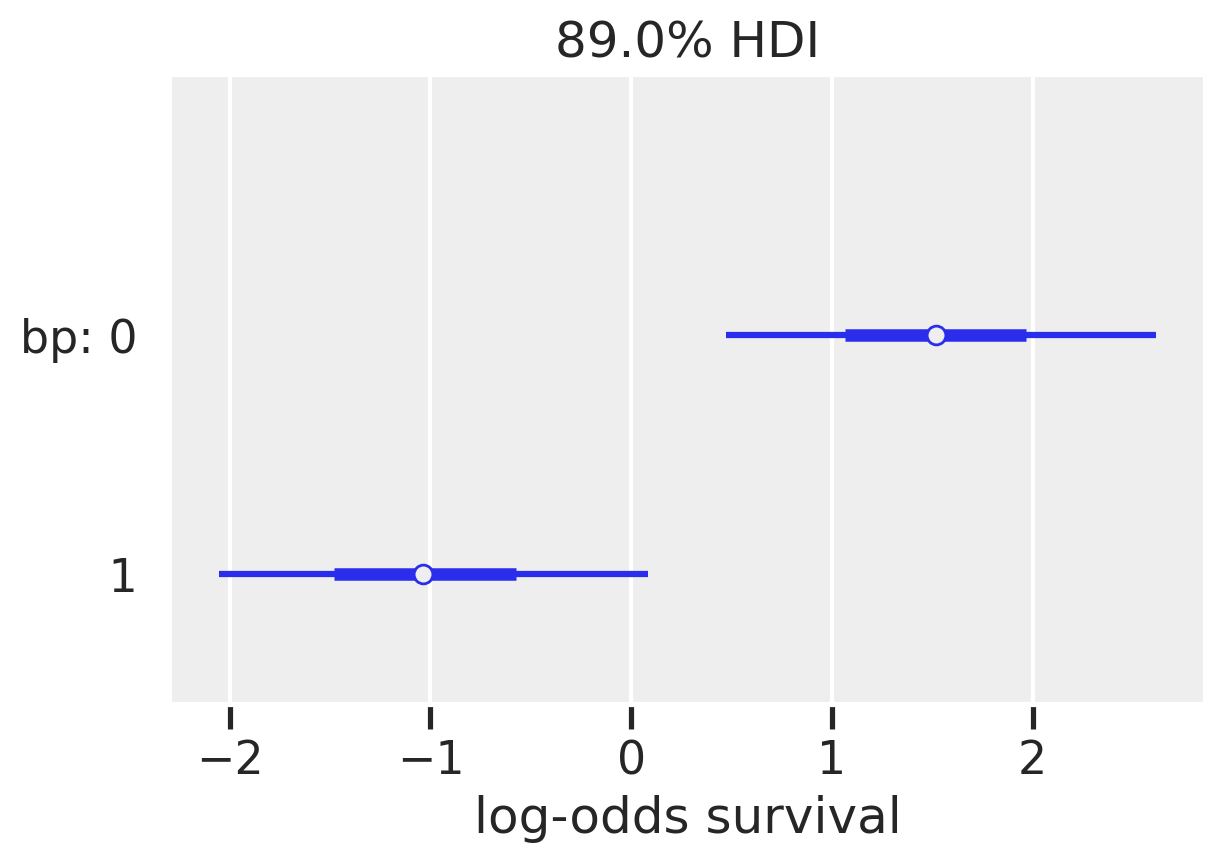

<IPython.core.display.Javascript object>

In [51]:
# Check values to compare with centered model.
az.plot_forest(trace_13_2pr, var_names=["bp"], combined=True)
plt.xlabel("log-odds survival")

Not surprisingly, the presence of predation significantly reduces the probability of survival.

## Model with `size` alone

**Model 13.2s equation**

$$S_i \text{ ~ } \text{Binomial}(N_i,p_i)$$

$$\text{logit}(p_i) = \alpha_{\text{TANK}[i]} + \beta_{\text{SIZE}[i]}$$

$$\alpha_j \text{ ~ } \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\beta_j \text{ ~ } \text{Normal}(0, 1) \tag{regularizing prior}$$

$$\bar{\alpha} \text{ ~ } \text{Normal}(0, 1.5) \tag{prior for average tank}$$

$$\sigma \text{ ~ } \text{Exponential}(1) \tag{prior for standard deviation of tanks}$$

**Model 13.2sr equation (non-centered)**

$$S_i \text{ ~ } \text{Binomial}(N_i,p_i)$$

$$\text{logit}(p_i) = \bar{\alpha} + z_{\text{TANK}[i]}\sigma + \beta_{\text{SIZE}[i]}$$

$$z_j \text{ ~ } \text{Normal}(0, 1) \tag{standardized tank intercepts}$$

$$\beta_j \text{ ~ } \text{Normal}(0, 1) \tag{regularizing prior}$$

$$\bar{\alpha} \text{ ~ } \text{Normal}(0, 1.5) \tag{prior for average tank}$$

$$\sigma \text{ ~ } \text{Exponential}(1) \tag{prior for standard deviation of tanks}$$

In [59]:
df_frogs["size_code"] = pd.Categorical(
    df_frogs["size"], categories=["small", "big"]
).codes

<IPython.core.display.Javascript object>

In [60]:
df_frogs.head()

,density,pred,size,surv,propsurv,pred_code,size_code
0,10,no,big,9,0.9,0,1
1,10,no,big,10,1.0,0,1
2,10,no,big,7,0.7,0,1
3,10,no,big,10,1.0,0,1
4,10,no,small,9,0.9,0,0


<IPython.core.display.Javascript object>

In [62]:
# non-centered version
with pm.Model() as m_13_2sr:
    # prior for average tank
    a_bar = pm.Normal("a_bar", 0.0, 1.5)

    # prior for SD of tanks
    sigma = pm.Exponential("sigma", 1.0)

    # standardized tank intercepts
    z = pm.Normal("z", 0, 1, shape=n_tanks)

    # regularizing prior
    bs = pm.Normal("bs", 0, 1, shape=len(df_frogs["size_code"].unique()))

    p = pm.math.invlogit(a_bar + z[tank] * sigma + bs[df_frogs["size_code"]])

    S = pm.Binomial("S", n=df_frogs["density"], p=p, observed=df_frogs["surv"])

    trace_13_2sr = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bs, z, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


<IPython.core.display.Javascript object>

### Impact of size

Text(0.5, 0, 'log-odds survival')

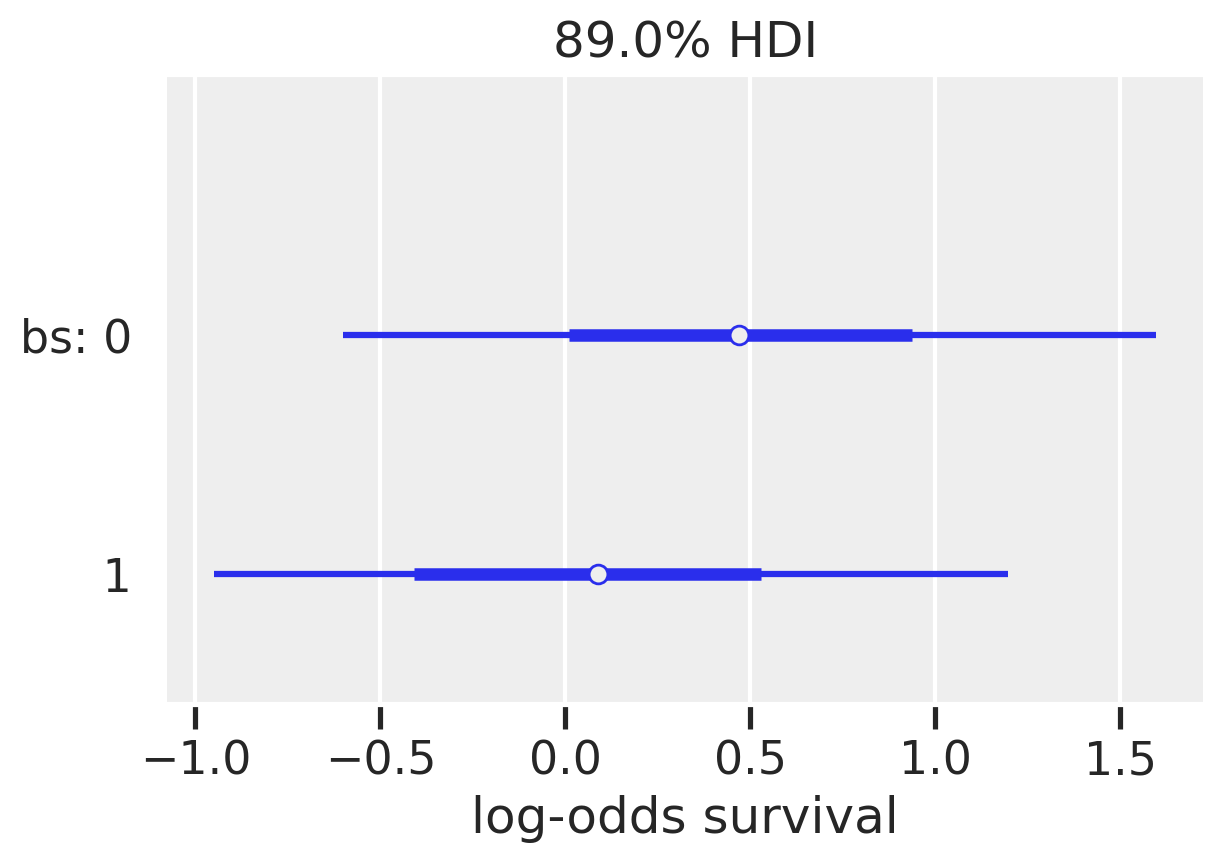

<IPython.core.display.Javascript object>

In [64]:
# Check values to compare with centered model.
az.plot_forest(trace_13_2sr, var_names=["bs"], combined=True)
plt.xlabel("log-odds survival")

Size does not make a big impact on survival rate.

## Model with both predictors

**Model 13.2both equation (non-centered)**

$$S_i \text{ ~ } \text{Binomial}(N_i,p_i)$$

$$\text{logit}(p_i) = \bar{\alpha} + z_{\text{TANK}[i]}\sigma + \beta_{\text{SIZE}[i]} + \beta_{\text{PRED}[i]}$$

$$z_j \text{ ~ } \text{Normal}(0, 1) \tag{standardized tank intercepts}$$

$$\beta_{\text{SIZE}[j]} \text{ ~ } \text{Normal}(0, 1) \tag{regularizing prior for size}$$

$$\beta_{\text{PRED}[j]} \text{ ~ } \text{Normal}(0, 1) \tag{regularizing prior for predation}$$

$$\bar{\alpha} \text{ ~ } \text{Normal}(0, 1.5) \tag{prior for average tank}$$

$$\sigma \text{ ~ } \text{Exponential}(1) \tag{prior for standard deviation of tanks}$$

In [66]:
# non-centered version
with pm.Model() as m_13_2both:
    # prior for average tank
    a_bar = pm.Normal("a_bar", 0.0, 1.5)

    # prior for SD of tanks
    sigma = pm.Exponential("sigma", 1.0)

    # standardized tank intercepts
    z = pm.Normal("z", 0, 1, shape=n_tanks)

    # regularizing priors
    bs = pm.Normal("bs", 0, 1, shape=len(df_frogs["size_code"].unique()))
    bp = pm.Normal("bp", 0, 1, shape=len(df_frogs["pred_code"].unique()))

    p = pm.math.invlogit(
        a_bar + z[tank] * sigma + bs[df_frogs["size_code"]] + bp[df_frogs["pred_code"]]
    )

    S = pm.Binomial("S", n=df_frogs["density"], p=p, observed=df_frogs["surv"])

    trace_13_2both = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bp, bs, z, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


<IPython.core.display.Javascript object>

## Model with interaction

In [71]:
# adapted R homework solution but not 100% sure it's correct
with pm.Model() as m_13_2int:
    # prior for average tank
    a_bar = pm.Normal("a_bar", 0.0, 1.5)

    # prior for SD of tanks
    sigma = pm.Exponential("sigma", 1.0)

    # standardized tank intercepts
    z = pm.Normal("z", 0, 1, shape=n_tanks)

    # regularizing priors
    bs = pm.Normal("bs", 0, 1, shape=len(df_frogs["size_code"].unique()))
    bp = pm.Normal("bp", 0, 1, shape=len(df_frogs["pred_code"].unique()))

    p = pm.math.invlogit(
        a_bar
        + z[tank] * sigma
        + bs[df_frogs["size_code"]]
        + bp[df_frogs["pred_code"]] * df_frogs["size_code"]
    )

    S = pm.Binomial("S", n=df_frogs["density"], p=p, observed=df_frogs["surv"])

    trace_13_2int = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bp, bs, z, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


<IPython.core.display.Javascript object>

## Comparison of sigma terms

In [69]:
az.summary(trace_13_2pr, var_names=["sigma"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma,0.82,0.14,0.605,1.044,0.003,0.002,1753.0,1753.0,1772.0,3063.0,1.0


<IPython.core.display.Javascript object>

In [70]:
az.summary(trace_13_2sr, var_names=["sigma"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma,1.626,0.222,1.278,1.966,0.007,0.005,1014.0,990.0,1061.0,1510.0,1.0


<IPython.core.display.Javascript object>

In [68]:
az.summary(trace_13_2both, var_names=["sigma"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma,0.772,0.147,0.549,0.999,0.003,0.002,1775.0,1775.0,1799.0,2288.0,1.0


<IPython.core.display.Javascript object>

# Question 2 (13H1)

In 1980, a typical Bengali woman could have 5 or more children in her lifetime. By the year 2000, a typical Bengali woman had only 2 or 3. You’re going to look at a historical set of data, when contraception was widely available but many families chose not to use it. These data reside in `data(bangladesh)` and come from the 1988 Bangladesh Fertility Survey. Each row is one of 1934 women. There are six variables, but you can focus on two of them for this practice problem:

1. `district`: ID number of administrative district each woman resided in
2. `use.contraception`: An indicator (0/1) of whether the woman was using contraception

The first thing to do is ensure that the cluster variable, `district`, is a contiguous set of integers. Recall that these values will be index values inside the model. If there are gaps, you’ll have parameters for which there is no data to inform them. Worse, the model probably won’t run. Look at the unique values of the `district` variable:

```
# R code 13.40
sort(unique(d$district)) 
[1] 1 2 3 4 5 ... 51 52 53 55 56 57.... 61
```

District 54 is absent. So `district` isn’t yet a good index variable, because it’s not contiguous. This is easy to fix. Just make a new variable that is contiguous. This is enough to do it:

```
# R code 13.41
d$district_id  <-as.integer(as.factor(d$district))
sort(unique(d$district_id))
[1] 1 2 3 4 5 ... 60
```

Now there are 60 values, contiguous integers 1 to 60. Now, focus on predicting `use.contraception`, clustered by `district_id`. Fit both (1) a traditional fixed-effects model that uses an index variable for district and (2) a multilevel model with varying intercepts for district. Plot the predicted proportions of women in each district using contraception, for both the fixed-effects model and the varying-effects model. That is, make a plot in which district ID is on the horizontal axis and expected proportion using contraception is on the vertical. Make one plot for each model, or layer the monthe same plot, as you prefer. How do the models disagree? Can you explain the pattern of disagreement? In particular, can you explain the most extreme cases of disagreement, both why they happen where they do and why the models reach different inferences?

## Data exploration and setup

In [8]:
df_bangladesh = pd.read_csv(
    "../pymc3_ed_resources/resources/Rethinking/Data/bangladesh.csv",
    delimiter=";",
)
df_bangladesh.head()

,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


<IPython.core.display.Javascript object>

In [10]:
print("shape of df: ", df_bangladesh.shape)

shape of df:  (1934, 6)


<IPython.core.display.Javascript object>

Per the homework, fix the district variable since it is not a contiguous set of integers.. Luckily, this is easy enough to do with `pd.Categorical`.

In [12]:
df_bangladesh["district_code"] = pd.Categorical(df_bangladesh["district"]).codes

<IPython.core.display.Javascript object>

In [17]:
# inspect and see that it's now 0-indexed for Python

print(
    "df head: ", df_bangladesh[["district", "district_code"]].drop_duplicates().head()
)

# and also that it accounts for missing district 54
print(
    "df tail: ", df_bangladesh[["district", "district_code"]].drop_duplicates().tail(10)
)

df head:       district  district_code
0           1              0
117         2              1
137         3              2
139         4              3
169         5              4
df tail:        district  district_code
1622        51             50
1659        52             51
1720        53             52
1739        55             53
1745        56             54
1790        57             55
1817        58             56
1850        59             57
1860        60             58
1892        61             59


<IPython.core.display.Javascript object>

In [21]:
# Look outcome variable
df_bangladesh["use.contraception"].value_counts()

0    1175
1     759
Name: use.contraception, dtype: int64

<IPython.core.display.Javascript object>

## Fixed-effects model

Predict `use.contraception`. Since there are two outcomes, it makes sense to use a binomial GLM for this problem. We'll use an index variable for district and it will be an intercept only model.

**Model `mfe` equation**

$$C_i \text{ ~ } \text{Binomial}(1, p_i)$$

$$\text{logit}(p_i) = \alpha_{\text{district}[i]}$$

$$\alpha_j \text{ ~ } \text{Normal}(0, 1.5) \tag{regularizing prior}$$

In [26]:
with pm.Model() as mfe:

    # alpha prior, one for each district
    a = pm.Normal("a", 0, 1.5, shape=len(df_bangladesh["district_code"].unique()))

    # link function
    p = pm.math.invlogit(a[df_bangladesh["district_code"]])

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mfe = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


<IPython.core.display.Javascript object>

In [28]:
# Preview dataset
az.summary(trace_mfe).head()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.052,0.205,-1.389,-0.730,0.002,0.002,10791.0,8837.0,11082.0,2622.0,1.0
a[1],-0.584,0.452,-1.287,0.134,0.005,0.005,9885.0,4432.0,9897.0,2824.0,1.0
a[2],1.240,1.156,-0.647,2.980,0.012,0.014,8647.0,3240.0,8900.0,2517.0,1.0
a[3],-0.003,0.362,-0.572,0.579,0.004,0.007,9690.0,1409.0,9763.0,2666.0,1.0
a[4],-0.569,0.330,-1.077,-0.020,0.004,0.003,8362.0,4628.0,8431.0,2847.0,1.0


<IPython.core.display.Javascript object>

Text(0.5, 0, 'log-odds')

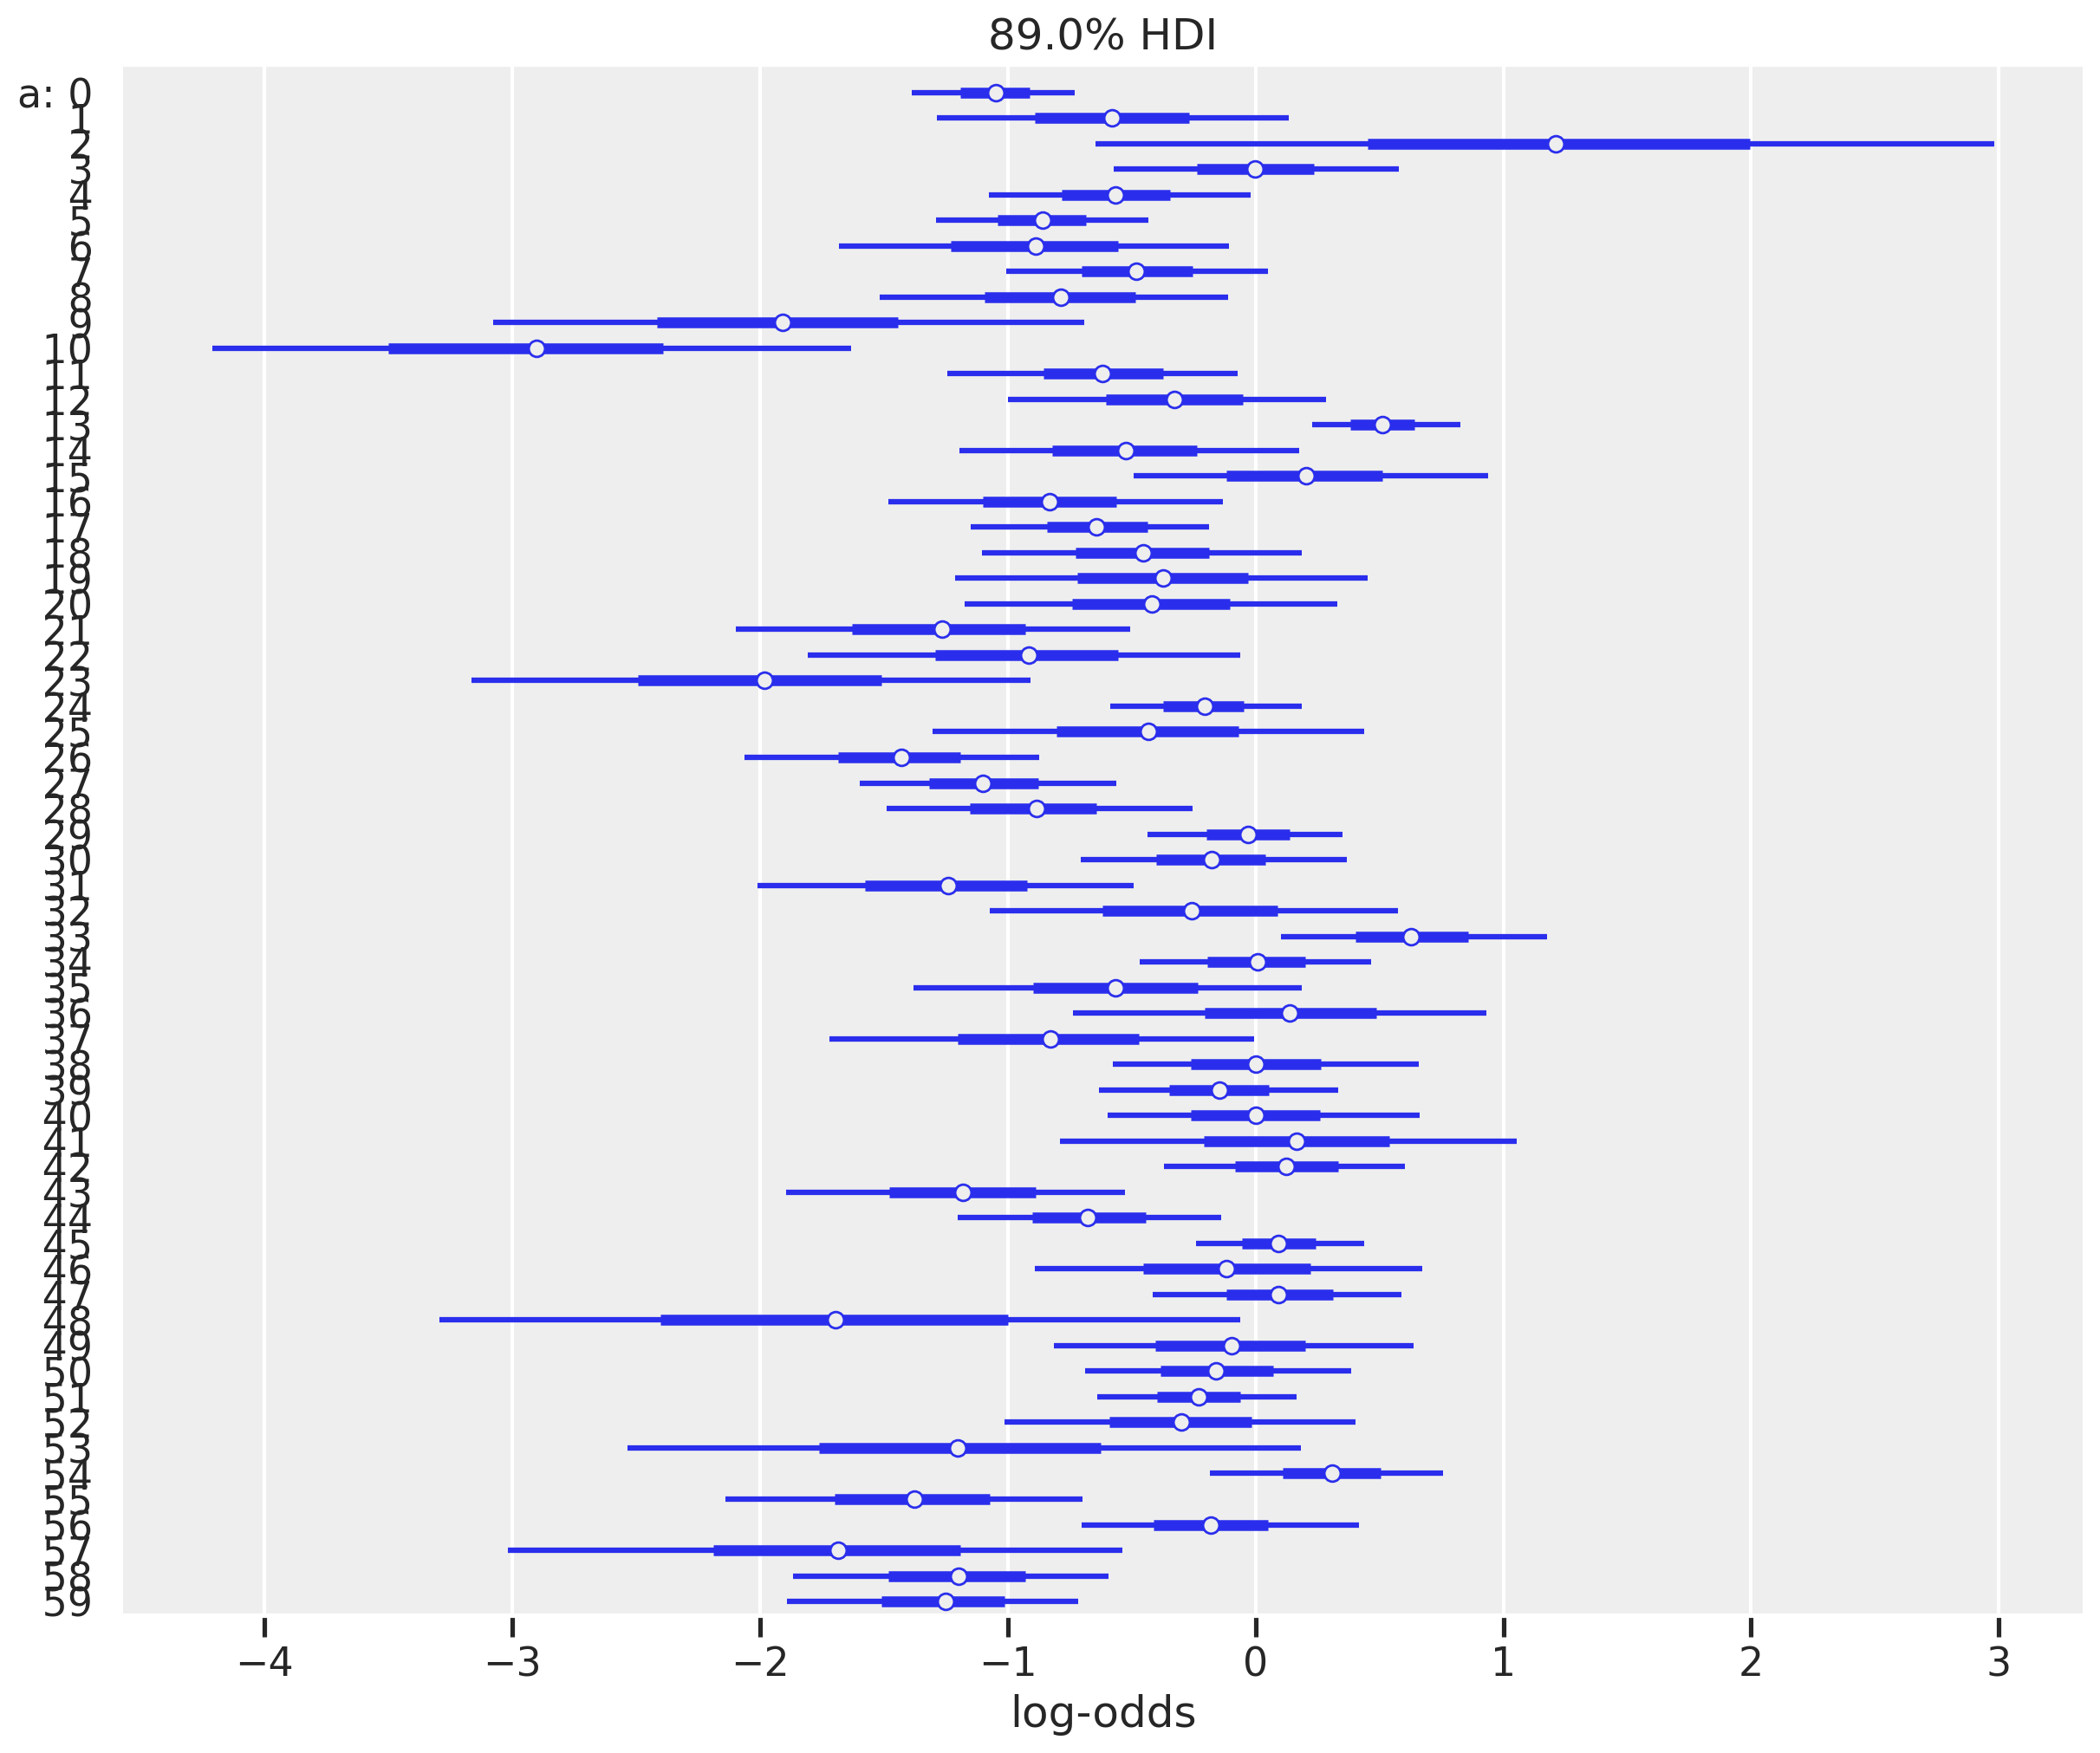

<IPython.core.display.Javascript object>

In [33]:
f, ax1 = plt.subplots(figsize=(12, 10))
az.plot_forest(trace_mfe, combined=True, ax=ax1)
ax1.set_xlabel("log-odds")

The results indicate that some districts are much less likely to use contraception (negative log-odds) than other districts (log-odds that span zero or are wholly positive).

This is seen by looking at the raw data. For example, the district indexed 10 is the most negative in terms of log-odds while index 2 is most positive. In index 10, there is no woman that has used contraception.

In [34]:
df_bangladesh[df_bangladesh["district_code"] == 10]

,woman,district,use.contraception,living.children,age.centered,urban,district_code
364,365,11,0,1,-9.5599,0,10
365,366,11,0,1,-8.5599,0,10
366,367,11,0,2,-5.5599,0,10
367,368,11,0,2,18.4400,0,10
368,369,11,0,1,-8.5599,0,10
369,370,11,0,1,-9.5599,0,10
370,371,11,0,1,-12.5590,0,10
371,372,11,0,1,3.4400,0,10
372,373,11,0,1,-8.5599,0,10
373,374,11,0,4,19.4400,0,10


<IPython.core.display.Javascript object>

## Mixed-effects model

Now let's use a mixed effects model where information is allowed to pool between clusters. This would make more sense since there's a varying number of women in each district.

In [43]:
df_bangladesh.groupby("district_code").count().iloc[:, 0].head(10)

district_code
0    117
1     20
2      2
3     30
4     39
5     65
6     18
7     37
8     23
9     13
Name: woman, dtype: int64

<IPython.core.display.Javascript object>

 For example, district index 2 has only 2 people. We identified that as a district that is most likely to use contraception in the fixed effects model but now we'd place less confidence on this point due to the low number. The mixed effects model will account for this.

**Model `mme` equation**

$$C_i \text{ ~ } \text{Binomial}(1, p_i)$$

$$\text{logit}(p_i) = \alpha_{\text{district}[i]}$$

$$\alpha_j \text{ ~ } \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\bar{\alpha_j} \text{ ~ } \text{Normal}(0, 1.5) \tag{regularizing prior}$$

$$\sigma \text{ ~ } \text{Exponential}(1)$$

In [46]:
# multilevel model, non-centered version
with pm.Model() as m_13_2sr:

    # prior for average district
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of districts
    sigma = pm.Exponential("sigma", 1.0)

    # alpha priors for each district
    a = pm.Normal("a", a_bar, sigma, shape=len(df_bangladesh["district_code"].unique()))

    # link function
    p = pm.math.invlogit(a[df_bangladesh["district_code"]])

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mme = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


<IPython.core.display.Javascript object>

It looks like there are no divergences here so we don't have to worry about re-parameterizing. Let's take a look now.

In [47]:
az.summary(trace_mme)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.540,0.088,-0.679,-0.397,0.002,0.001,3125.0,3125.0,3125.0,3066.0,1.00
a[0],-0.992,0.198,-1.299,-0.679,0.003,0.002,5931.0,5154.0,5973.0,2419.0,1.00
a[1],-0.599,0.360,-1.144,-0.001,0.004,0.004,7047.0,3716.0,7138.0,2443.0,1.01
a[2],-0.240,0.501,-1.003,0.559,0.006,0.008,7605.0,2191.0,7501.0,3176.0,1.00
a[3],-0.179,0.298,-0.652,0.309,0.004,0.004,6683.0,2486.0,6638.0,3036.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
a[56],-0.300,0.287,-0.741,0.169,0.003,0.003,7417.0,3515.0,7412.0,3092.0,1.00
a[57],-0.997,0.443,-1.680,-0.266,0.006,0.005,5220.0,3757.0,5335.0,2690.0,1.00
a[58],-0.997,0.326,-1.518,-0.490,0.004,0.003,5811.0,4553.0,6008.0,2759.0,1.00
a[59],-1.054,0.303,-1.540,-0.588,0.004,0.003,5965.0,4850.0,6009.0,2550.0,1.00


<IPython.core.display.Javascript object>

[Text(0.5, 0, 'log-odds'), Text(0.5, 1.0, 'mixed model')]

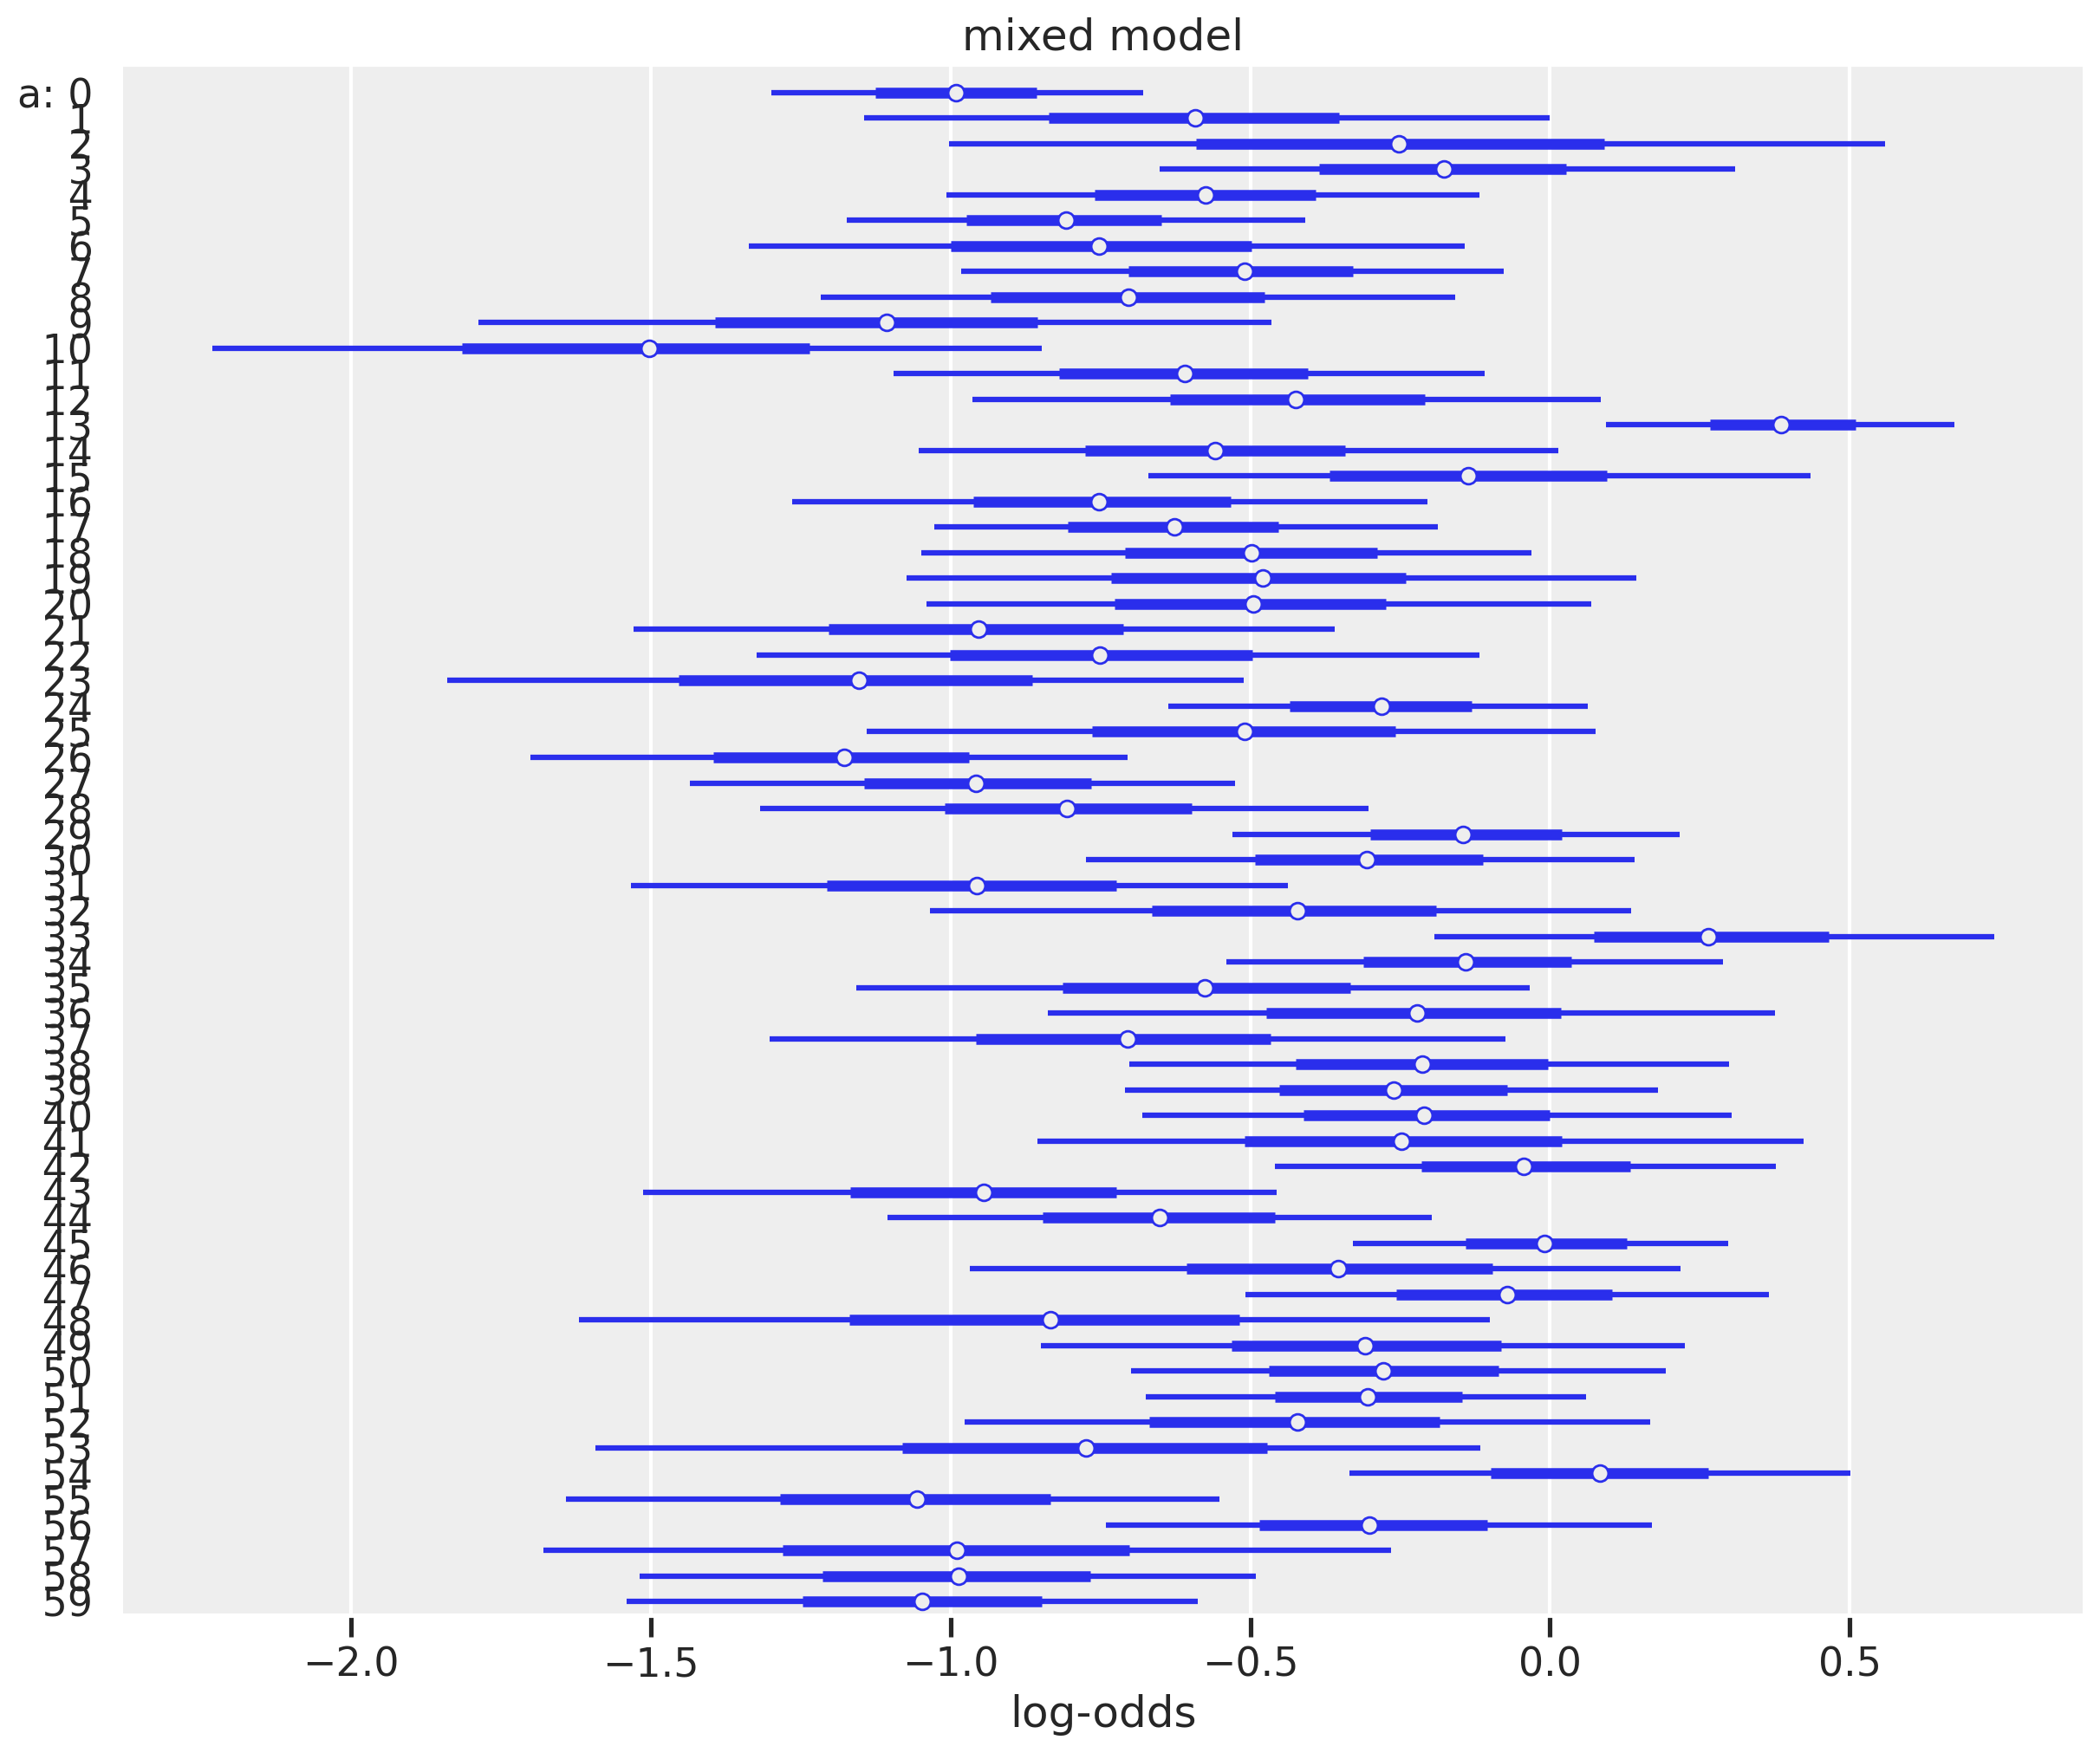

<IPython.core.display.Javascript object>

In [54]:
f, ax1 = plt.subplots(figsize=(12, 10))
az.plot_forest(trace_mme, var_names="a", combined=True, ax=ax1)
ax1.set(xlabel="log-odds", title="mixed model")

Note how the district with index 2 is a lot less confident now. The prediction interval spans log-odds of 0 now. We'll look at this more closely in the comparison.

## Comparison of fixed-effects and mixed-effects models

Per the homework assignment, let's plot the predicted proportion of women in each district using contraception. We'll use the `logistic` function to transform the log-odds back on the probability scale.

In [100]:
df_summary.head()

,index,mean_x,sd_x,hdi_5.5%_x,hdi_94.5%_x,mean_y,sd_y,hdi_5.5%_y,hdi_94.5%_y,n_women
0,a[0],-1.052,0.205,-1.389,-0.730,-0.992,0.198,-1.299,-0.679,117
1,a[1],-0.584,0.452,-1.287,0.134,-0.599,0.360,-1.144,-0.001,20
2,a[2],1.240,1.156,-0.647,2.980,-0.240,0.501,-1.003,0.559,2
3,a[3],-0.003,0.362,-0.572,0.579,-0.179,0.298,-0.652,0.309,30
4,a[4],-0.569,0.330,-1.077,-0.020,-0.577,0.279,-1.007,-0.118,39


<IPython.core.display.Javascript object>

[(-2.0, 60.0),
 (0.0, 1.0),
 Text(0.5, 0, 'district index'),
 Text(0, 0.5, 'proportion predicted\nfor contraception use')]

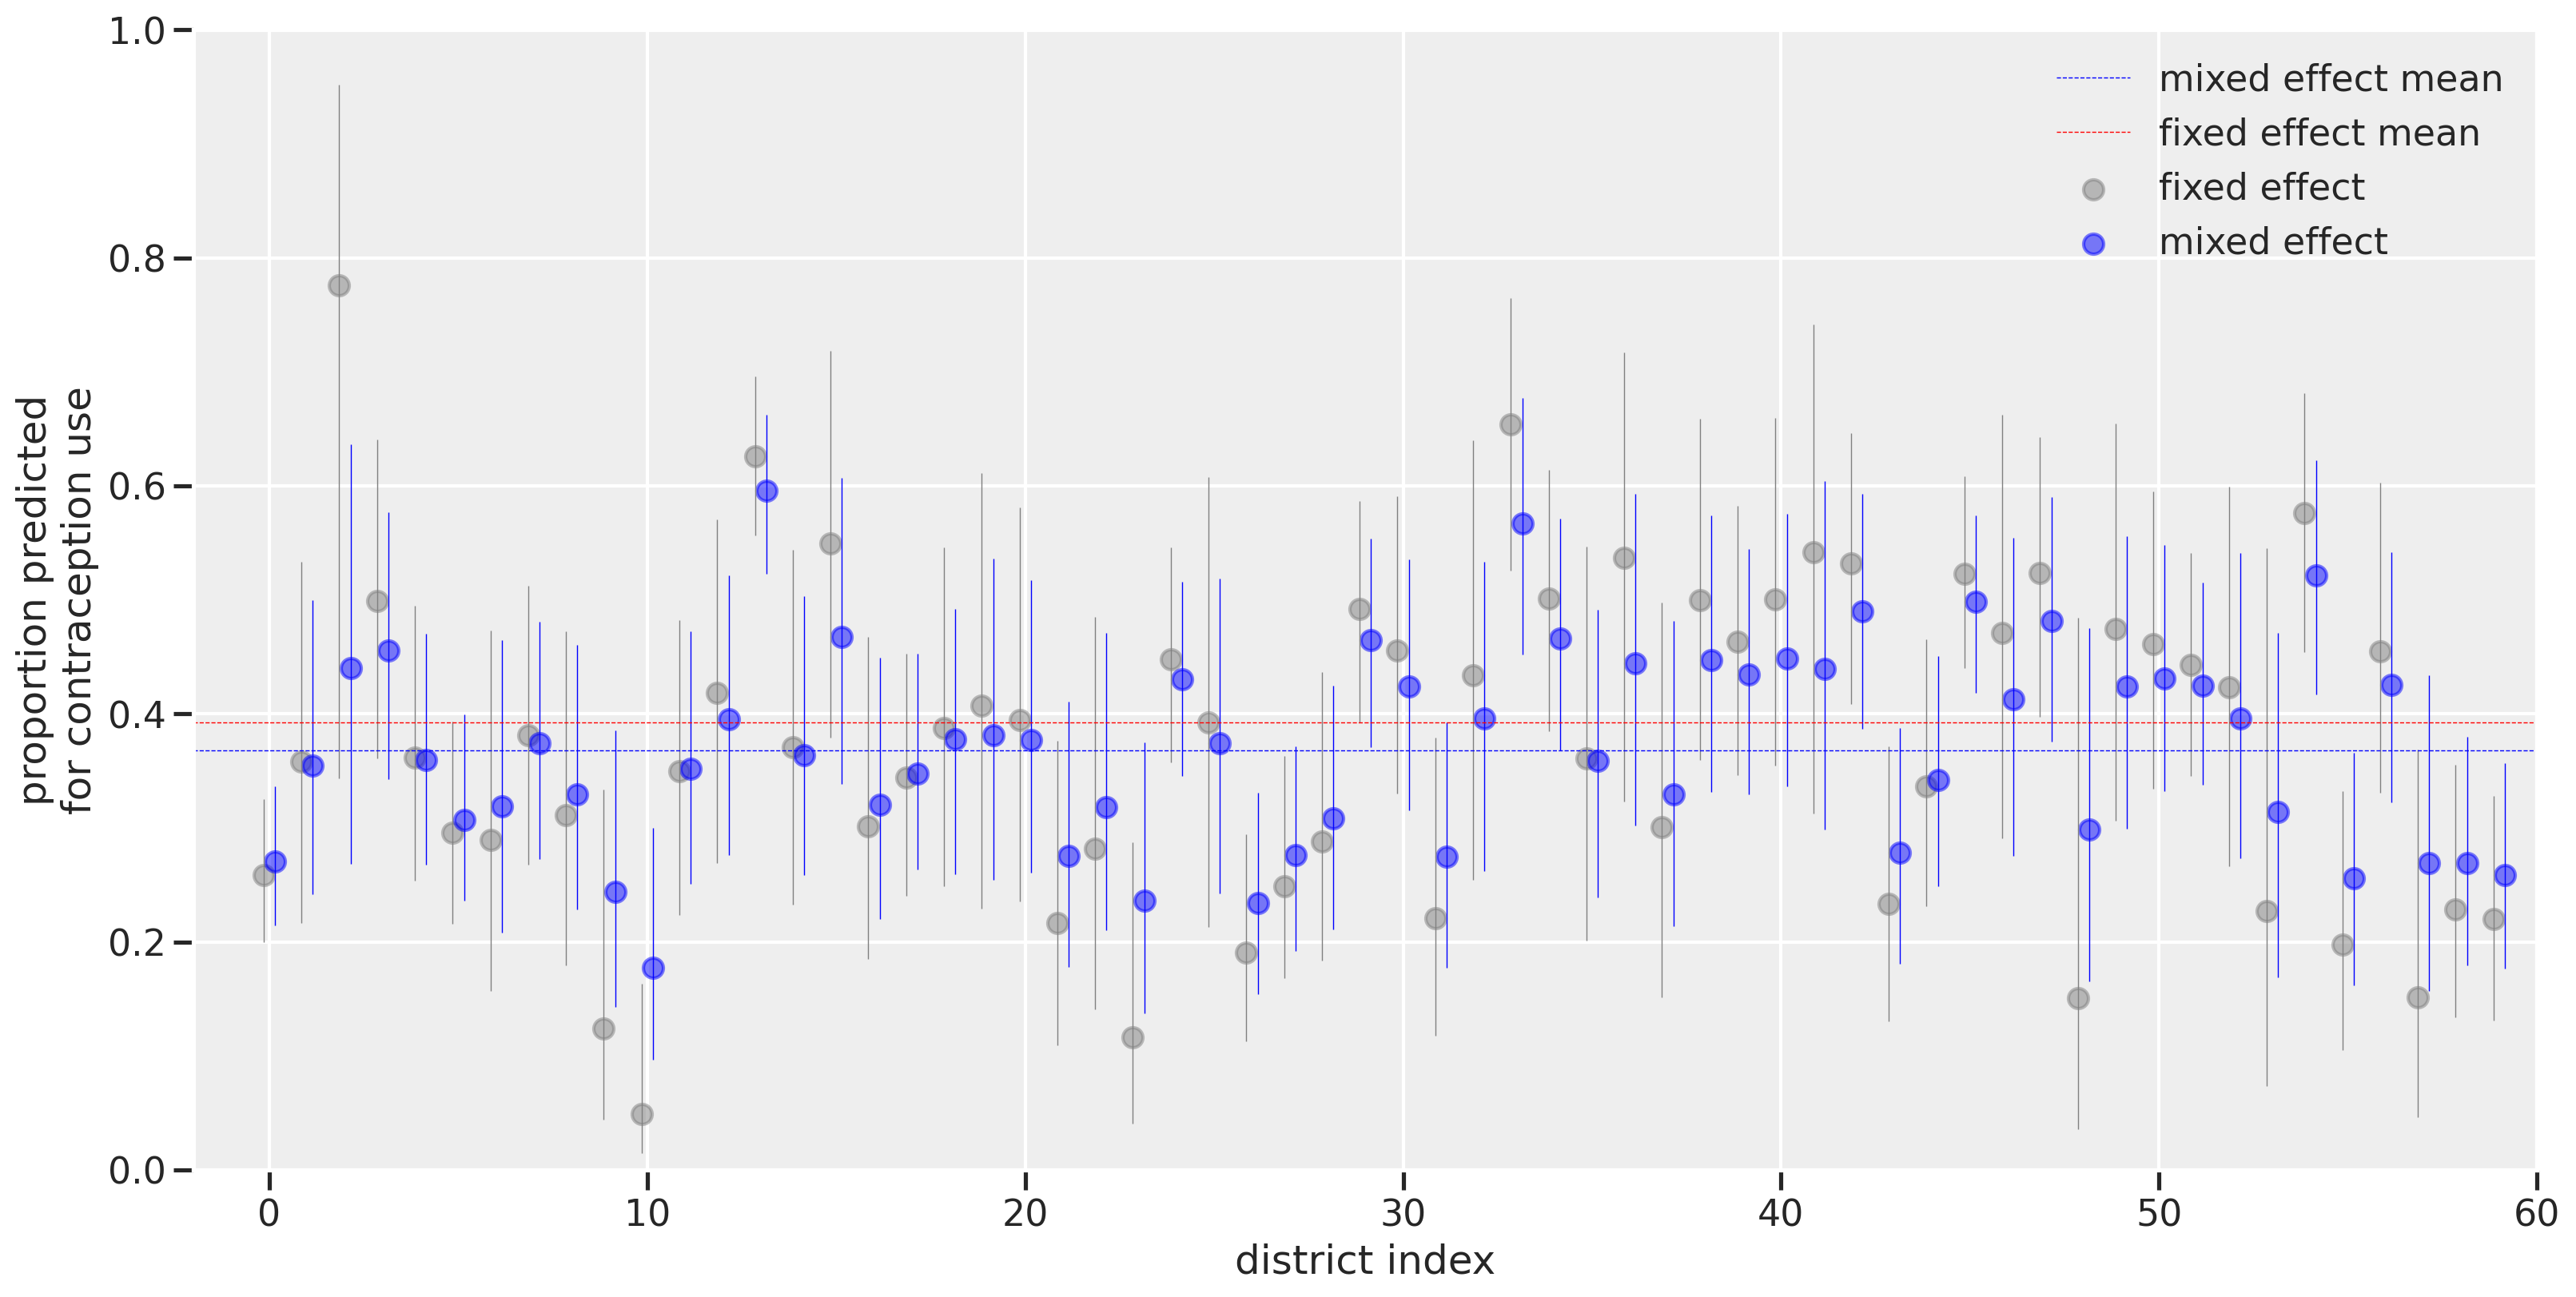

<IPython.core.display.Javascript object>

In [122]:
f, ax1 = plt.subplots(figsize=(16, 8))

# Plot means
ax1.scatter(
    df_summary.index - 0.15,
    logistic(df_summary["mean_x"]),
    color="gray",
    alpha=0.5,
    label="fixed effect",
)
ax1.scatter(
    df_summary.index + 0.15,
    logistic(df_summary["mean_y"]),
    color="blue",
    alpha=0.5,
    label="mixed effect",
)

# Plot uncertainties
ax1.vlines(
    x=df_summary.index - 0.15,
    ymin=logistic(df_summary["hdi_5.5%_x"]),
    ymax=logistic(df_summary["hdi_94.5%_x"]),
    color="gray",
    linewidth=0.5,
)

ax1.vlines(
    x=df_summary.index + 0.15,
    ymin=logistic(df_summary["hdi_5.5%_y"]),
    ymax=logistic(df_summary["hdi_94.5%_y"]),
    color="blue",
    linewidth=0.5,
)

# Plot average mixed effect line
me_mean = logistic(az.summary(trace_mme).loc["a_bar", "mean"])
ax1.plot(
    [-10, 62],
    [me_mean, me_mean],
    color="blue",
    lw=0.5,
    linestyle="--",
    alpha=1,
    label="mixed effect mean",
)

# Plot raw fixed effect line
fe_mean = df_bangladesh["use.contraception"].mean()
ax1.plot(
    [-10, 62],
    [fe_mean, fe_mean],
    color="red",
    lw=0.5,
    linestyle="--",
    alpha=1,
    label="fixed effect mean",
)

ax1.legend()
ax1.set(
    xlim=[-2, 60],
    ylim=[0, 1],
    xlabel="district index",
    ylabel="proportion predicted\nfor contraception use",
)

Let's start off by looking at how the uncertainty for each district is in the fixed-effects versus mixed-effects model for each district.

In [99]:
col2inspect = ["mean", "sd", "hdi_5.5%", "hdi_94.5%"]
df_summary = pd.merge(
    az.summary(trace_mfe)[col2inspect],
    az.summary(trace_mme)[col2inspect],
    how="inner",
    left_index=True,
    right_index=True,
)

# Reset index
df_summary.reset_index(inplace=True)

# Add number of women for each district
df_summary["n_women"] = df_bangladesh.groupby("district_code").count().iloc[:, 0]

df_summary.head()

,index,mean_x,sd_x,hdi_5.5%_x,hdi_94.5%_x,mean_y,sd_y,hdi_5.5%_y,hdi_94.5%_y,n_women
0,a[0],-1.052,0.205,-1.389,-0.730,-0.992,0.198,-1.299,-0.679,117
1,a[1],-0.584,0.452,-1.287,0.134,-0.599,0.360,-1.144,-0.001,20
2,a[2],1.240,1.156,-0.647,2.980,-0.240,0.501,-1.003,0.559,2
3,a[3],-0.003,0.362,-0.572,0.579,-0.179,0.298,-0.652,0.309,30
4,a[4],-0.569,0.330,-1.077,-0.020,-0.577,0.279,-1.007,-0.118,39


<IPython.core.display.Javascript object>

[(0.0, 1.2),
 (0.0, 1.2),
 Text(0.5, 0, 'fixed effects SD'),
 Text(0, 0.5, 'mixed effects SD')]

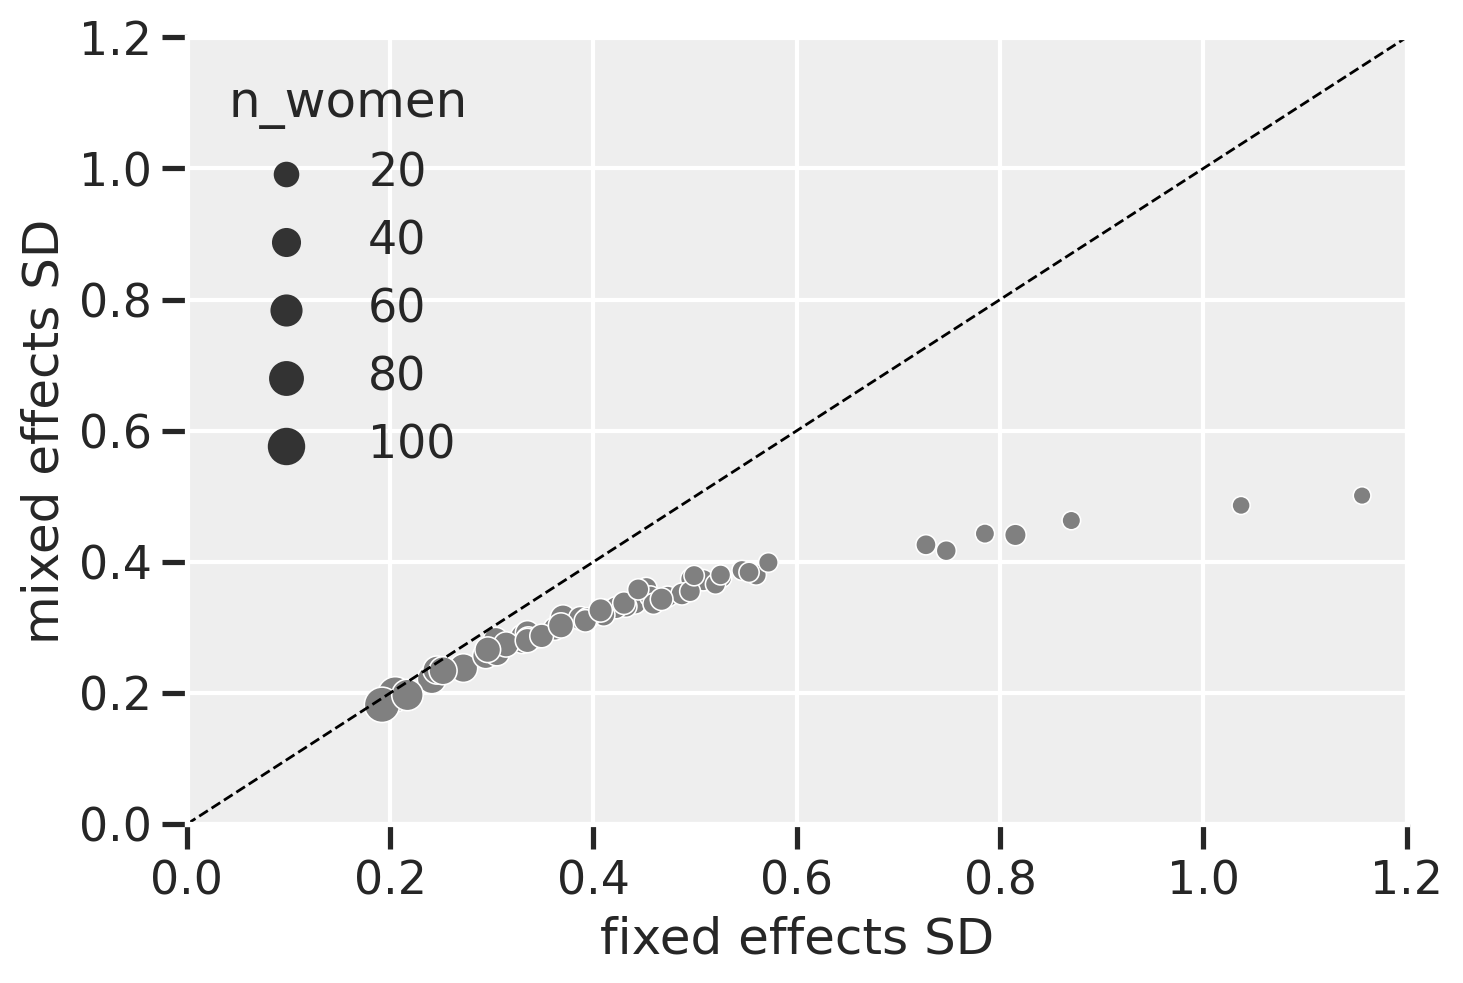

<IPython.core.display.Javascript object>

In [74]:
f, ax1 = plt.subplots()
sns.scatterplot(
    data=df_summary, x="sd_x", y="sd_y", size="n_women", color="gray", ax=ax1
)
ax1.plot([0, 1.2], [0, 1.2], color="black", lw=1, linestyle="--")
ax1.set(
    xlim=[0, 1.2], ylim=[0, 1.2], xlabel="fixed effects SD", ylabel="mixed effects SD"
)

Here, we can see that the fixed effects model shows greater uncertainty, especially when the number of women in each district gets lower. When the number of women is high, the fixed effects shows uncertainty on par with the mixed effects model. Lower uncertainty with mixed effects is due to partial pooling.

## Comparison with homework solution

It largely matched with McElreath's posted solutions. (The colors are flipped when comparing.)

# Question 3 (13H2)

Return to the Trolley data, data(Trolley), from Chapter 12. Define and fit a
varying intercepts model for these data. By this I mean to add an intercept parameter
for the individual to the linear model. Cluster the varying intercepts on individual
participants, as indicated by the unique values in the id variable. Include action,
intention, and contact as before. Compare the varying intercepts model and a
model that ignores individuals, using both WAIC/LOO and posterior predictions.
What is the impact of individual variation in these data?

## DAG

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


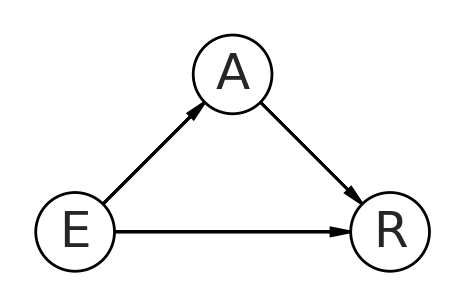

<IPython.core.display.Javascript object>

In [8]:
pipe_dag = CausalGraphicalModel(
    nodes=["E", "A", "R"],
    edges=[
        ("E", "A"),
        ("A", "R"),
        ("E", "R"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "E": (0, 0),
    "A": (1, 1),
    "R": (2, 0),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


Appendix: Environment and system parameters

In [33]:
%watermark -n -u -v -iv -w

Last updated: Fri Jul 02 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pandas    : 1.2.1
matplotlib: 3.3.4
arviz     : 0.11.1
pymc3     : 3.11.0
daft      : 0.1.0
json      : 2.0.9
numpy     : 1.20.1
seaborn   : 0.11.1
scipy     : 1.6.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>